# 160. mnist dataset 손글씨 인식 - Multi-class Classification

- Basic Fully Connected Layer 이용

- nn.CrossEntropyLoss 이용

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Dataset handling
- ``transforms.ToTensor()`` - image 를 tensor로 변환
- ```SubsetSampler``` - 주어진 인덱스 목록에서 무작위로 비복원 추출

In [3]:
# download mnist data
train_data = datasets.MNIST(root='./data', train=True,
                            download=True, transform=transforms.ToTensor())

test_data = datasets.MNIST(root='./data', train=False,
                           download=True, transform=transforms.ToTensor())

In [4]:
print(train_data)
print()
print(test_data)
print()
print(train_data[0][0].shape)
print(train_data[0][1])

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

torch.Size([1, 28, 28])
5


In [5]:
train_data[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

- Data 시각화

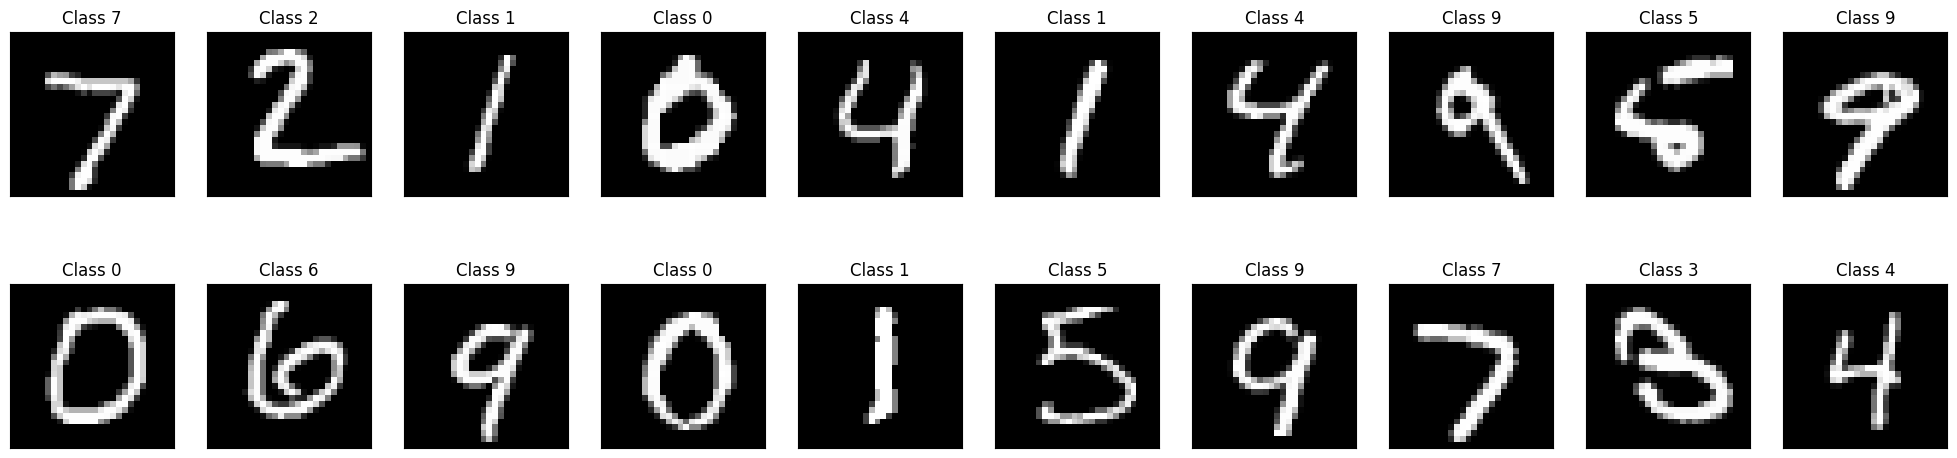

In [6]:
plt.figure(figsize=(25, 6))

for i, (x, y) in enumerate(test_data):
    if i > 19:
        break
    plt.subplot(2, 10, i+1)
    plt.imshow(x.view(28, 28), cmap='gray')
    plt.title("Class {}".format(y))
    plt.xticks([])
    plt.yticks([])

plt.show()

## Dataset Loader 생성

- Train dataset 을 Train 과 Validation set 으로 분리

In [7]:
# 검증 데이터셋(validation set)으로 사용할 전체 학습 데이터셋(train_dataset)의 비율 설정
valid_size = 0.2

# 학습 데이터셋의 총 데이터 수
num_train = len(train_data)

# 0부터 num_train-1까지의 인덱스 생성
indices = list(range(num_train))

# 데이터의 인덱스를 무작위로 섞습니다.
np.random.shuffle(indices)

# 학습 데이터셋과 검증 데이터셋을 분할할 위치 계산
# 예를 들어, 전체 데이터셋의 20%를 검증 데이터셋으로 사용하고자 할 때,
# 전체 데이터셋 크기에 valid_size(0.2)를 곱하여 분할 위치(split)를 계산
split = int(np.floor(valid_size * num_train))

# 계산된 분할 위치를 기준으로 학습 데이터셋과 검증 데이터셋의 인덱스를 분리
# split 이후의 인덱스는 학습 데이터셋으로, split 이전의 인덱스는 검증 데이터셋으로 사용됩니다.
train_idx, valid_idx = indices[split:], indices[:split]

# 학습 데이터셋과 검증 데이터셋에 대한 sampler 정의
# SubsetRandomSampler는 주어진 인덱스 리스트에 따라 무작위로 샘플을 추출합니다.
# 이를 통해 DataLoader가 데이터셋을 무작위로 추출할 수 있도록 합니다.
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

- train, validation, test dataset 으로 3 분할

In [8]:
batch_size = 128

# 훈련 데이터셋에서 배치 데이터를 로드하기 위한 DataLoader 생성
# `sampler=train_sampler`는 DataLoader가 데이터셋에서 샘플을 선택하는 방법을 정의합니다.
# 여기서는 `SubsetRandomSampler`를 사용하여 정의된 인덱스에 따라 데이터를 무작위로 샘플링합니다.
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                batch_size=batch_size, sampler=train_sampler)

# 검증 데이터셋을 위한 DataLoader를 생성합니다.
# `valid_sampler`를 사용하여 검증 데이터셋의 샘플링 방식을 정의합니다.
valid_loader = torch.utils.data.DataLoader(dataset=train_data,
                                batch_size=batch_size, sampler=valid_sampler)

# 테스트 데이터셋을 위한 DataLoader를 생성합니다.
# 테스트 데이터셋은 셔플하지 않으며(`shuffle=False`), 모델의 일반화 성능을 평가하는 데 사용됩니다.
test_loader  = torch.utils.data.DataLoader(dataset=test_data,
                                batch_size=batch_size, shuffle=False)

### Model custom build

- nn.Linear 이용
- activation 으로 relu 함수 적용
- 2개의 hidden layer와 dropout 사용

<img src="linear.png" width="600" />

In [9]:
class Net(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, D_out)
        self.dropout = nn.Dropout(0.2)
        self.relu  = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        out = self.fc3(x)
        return out

In [10]:
input_dim = 28 * 28
hidden_dim = 128
output_dim = 10

model = Net(input_dim, hidden_dim, output_dim)

### Model Summary

In [11]:
model

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

In [12]:
for k, v in model.state_dict().items():
    print(k, v.numel())

print("total trainable params", sum(p.numel() for p in model.parameters()))

fc1.weight 100352
fc1.bias 128
fc2.weight 16384
fc2.bias 128
fc3.weight 1280
fc3.bias 10
total trainable params 118282


In [13]:
for images, labels in train_loader:
    probs = model(images[0].view(-1, 28*28))
    break

print('outputs.shape : ', probs.shape)
# Look at sample probabilities
print("Sample probabilities:\n", probs[0].data)
# torch.argmax 로 가장 확률이 높은 output 선택
pred = torch.argmax(probs, dim=1)
pred

outputs.shape :  torch.Size([1, 10])
Sample probabilities:
 tensor([-0.0285, -0.0375,  0.1024,  0.0710, -0.1255,  0.0670, -0.0488, -0.0236,
        -0.0130,  0.0048])


tensor([2])

### softmax 함수를 사용하여 output row 를 확률 분포로 바꾼다. 공식은 다음과 같다.


<img src="softmax.png" width="400" />

- output row 의 각 element $y_i$ 를 $e^{y_i}$ 로 변경하여 모든 element 를 양수로 만든다.  
- 각 element 를 모든 element 의 합으로 나누어 합계가 1 이 되도록 한다.  
- predicted label 은 torch.max 를 이용하여 각 row 에서 highest probability 값을 고른다.  

### Loss Function 정의

<img src="crossentropy.png" width="400" />

- 손실함수는 categorical cross-entropy 지정

In [14]:
criterion = nn.CrossEntropyLoss()

model.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

- optimizer 는 Stochastic Gradient Descent 사용

In [15]:
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [16]:
len(valid_sampler)

12000

In [17]:
# 손실 및 정확도 기록을 위한 리스트 초기화
LOSS, VAL_LOSS, ACC, VAL_ACC = [], [], [], []
EPOCHS = 20  # 에폭 수 설정

for epoch in range(EPOCHS):

    model.train()  # 모델을 훈련 모드로 설정

    train_loss = 0  # 훈련 손실 초기화
    train_acc = 0  # 정확히 예측된 훈련 샘플 수 초기화

    for x, y in train_loader:   # 훈련 데이터 로더를 통해 배치 데이터를 가져옴
        x, y = x.to(device), y.to(device)  # 데이터를 현재 설정된 디바이스(CPU 또는 GPU)로 이동

        z = model(x.view(-1, 28 * 28))  # 모델에 입력 데이터를 전달하여 예측값을 계산
        loss = criterion(z, y)  # 손실 함수를 사용하여 손실 계산
        train_loss += loss.item()  # 배치 손실을 누적
        _, y_pred = torch.max(z, 1)  # 예측된 클래스 계산 (최대 확률을 가진 인덱스)
        train_acc += (y_pred == y).sum().item()  # 정확히 예측된 샘플 수를 누적

        optimizer.zero_grad()  # 옵티마이저의 그라디언트를 0으로 초기화
        loss.backward()  # 손실에 대한 그라디언트 계산 (역전파)
        optimizer.step()  # 모델의 파라미터 업데이트

    # 에폭 당 평균 훈련 손실 및 정확도 계산
    train_loss /= len(train_sampler)
    train_acc /= len(train_sampler)
    LOSS.append(train_loss)
    ACC.append(train_acc)

    model.eval()  # 모델을 평가 모드로 설정

    val_loss = 0  # 검증 손실 초기화
    val_acc = 0  # 정확히 예측된 검증 샘플 수 초기화
    for x, y in valid_loader:  # 검증 데이터 로더를 통해 배치 데이터를 가져옴
        x, y = x.to(device), y.to(device)

        z = model(x.view(-1, 28 * 28))
        loss = criterion(z, y)
        val_loss += loss.item()
        _, y_pred = torch.max(z, 1)
        val_acc += (y_pred == y).sum().item()

    # 에폭 당 평균 검증 손실 및 정확도 계산
    val_loss /= len(valid_sampler)
    val_acc /= len(valid_sampler)
    VAL_LOSS.append(val_loss)
    VAL_ACC.append(val_acc)

    # 에폭별 훈련 및 검증 손실, 정확도 출력
    print(f'epoch {epoch} ==> train loss: {train_loss:.5f}, \
          validation loss: {val_loss:.5f}, train acc: {train_acc:.5f}, validation acc: {val_acc:.5f}')

epoch 0 ==> train loss: 0.00263,           validation loss: 0.00129, train acc: 0.89756, validation acc: 0.95217
epoch 1 ==> train loss: 0.00165,           validation loss: 0.00119, train acc: 0.93796, validation acc: 0.95483
epoch 2 ==> train loss: 0.00152,           validation loss: 0.00130, train acc: 0.94483, validation acc: 0.95400
epoch 3 ==> train loss: 0.00135,           validation loss: 0.00122, train acc: 0.95023, validation acc: 0.96150
epoch 4 ==> train loss: 0.00138,           validation loss: 0.00113, train acc: 0.95069, validation acc: 0.95950
epoch 5 ==> train loss: 0.00131,           validation loss: 0.00109, train acc: 0.95458, validation acc: 0.96058
epoch 6 ==> train loss: 0.00129,           validation loss: 0.00109, train acc: 0.95533, validation acc: 0.96133
epoch 7 ==> train loss: 0.00121,           validation loss: 0.00103, train acc: 0.95815, validation acc: 0.96600
epoch 8 ==> train loss: 0.00121,           validation loss: 0.00107, train acc: 0.95790, validat

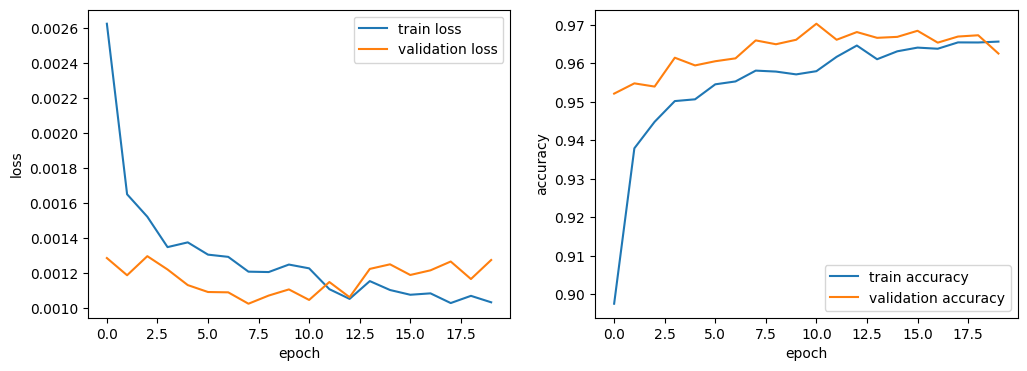

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(LOSS, label='train loss')
ax1.plot(VAL_LOSS, label='validation loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
ax2.plot(ACC, label='train accuracy')
ax2.plot(VAL_ACC, label='validation accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

## Model 평가 - Test set 사용

In [19]:
# 예측과 레이블을 저장할 리스트 초기화
predictions = []
labels = []

# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터 로더를 통해 데이터를 가져옴
for x, y in test_loader:
    # 데이터를 현재 설정된 디바이스(CPU 또는 GPU)로 이동
    x, y = x.to(device), y.to(device)
    # 모델에 입력 데이터를 전달하여 예측값을 계산
    z = model(x.view(-1, 28 * 28))
    # 예측된 클래스를 계산 (최대 확률을 가진 인덱스)
    _, y_pred = torch.max(z, 1)

    # 예측된 클래스와 실제 레이블을 CPU로 이동시킨 후 numpy 배열로 변환하여 리스트에 추가
    predictions.extend(y_pred.cpu().numpy())
    labels.extend(y.cpu().numpy())

# 올바르게 예측된 샘플의 인덱스 계산
correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
# 잘못 예측된 샘플의 인덱스 계산
incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]

# 정확도 계산 및 출력
# 올바르게 예측된 샘플 수를 전체 예측 수로 나누어 정확도를 계산
print("accuracy = {:.2f}%".format(len(correct_indices) / len(predictions) * 100))

accuracy = 96.70%


## Category 별 분류 성능 측정

accuracy of 0 = 98.16%
accuracy of 1 = 98.77%
accuracy of 2 = 96.41%
accuracy of 3 = 94.85%
accuracy of 4 = 95.21%
accuracy of 5 = 95.52%
accuracy of 6 = 97.08%
accuracy of 7 = 96.98%
accuracy of 8 = 96.51%
accuracy of 9 = 97.13%


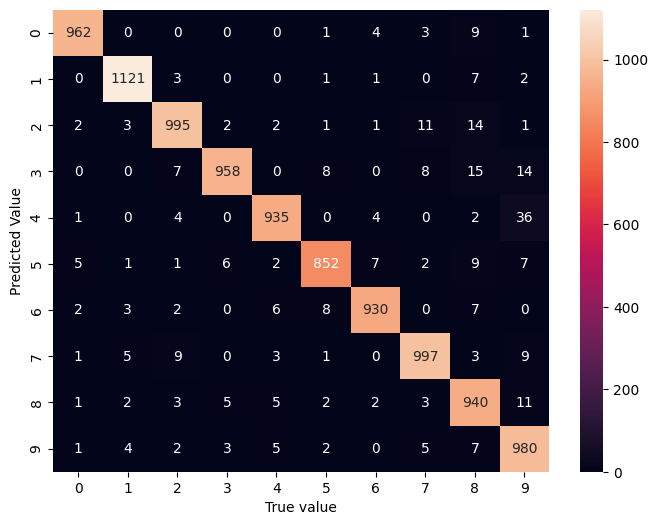

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set_xlabel('True value')
ax.set_ylabel('Predicted Value')

for i in range(10):
    print(f"accuracy of {i} = {cm[i][i] / cm[i].sum() * 100:.2f}%")

## Sample Test 결과 시각화

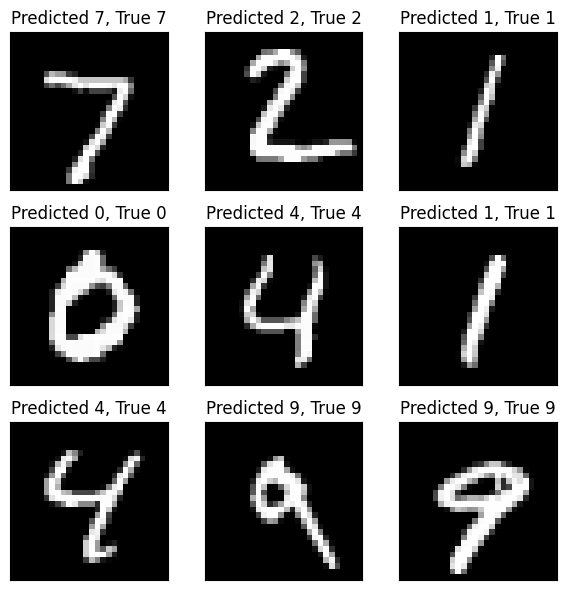

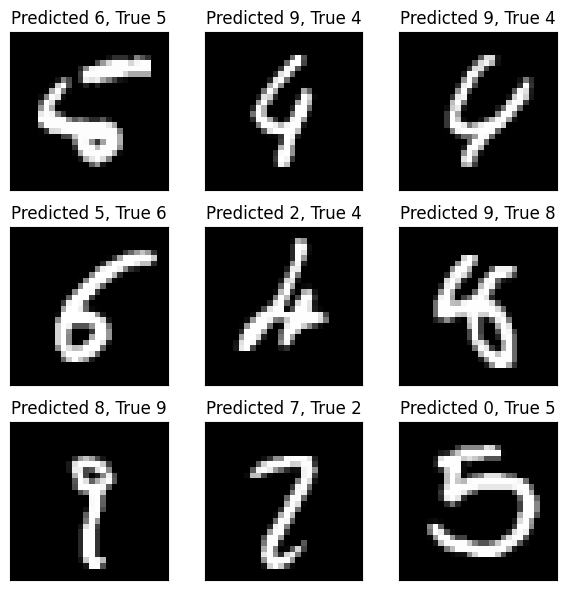

In [21]:
plt.figure(figsize=(6, 6))
for i, idx in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_data[idx][0].view(28, 28), cmap='gray')
    plt.title("Predicted {}, True {}".format(predictions[idx], labels[idx]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

plt.figure(figsize=(6, 6))
for i, idx in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_data[idx][0].view(28, 28), cmap='gray')
    plt.title("Predicted {}, True {}".format(predictions[idx], labels[idx]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()